# Workflow

This colab aims in labeling the NY data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea: 
* compute 7 -day moving average
* 14 days data compare with next 14 days rolling window
* split the % as buckets 
* label the data as per bucket

In [233]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [235]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [236]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_Covid-19.csv     Newyork_combinedAug22.csv  NY-CovidAug22.csv
CA-CovidAug22.csv   Newyork_combined.csv       queens_all_combined.csv
mask_rule.csv	    NY_Covid-19.csv	       queens_all_filtered.csv
mask_rule_data.csv  NY-CovidAug21.csv	       Queens_county.csv


# Loading NY data

In [237]:
NY_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/Newyork_combinedAug22.csv',low_memory=False)
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0


## Computing rolling average

In [238]:
NY_combined_data.iloc[:,15]

0       0
1       0
2       0
3       0
4       0
       ..
9685    1
9686    0
9687    0
9688    0
9689    0
Name: New cases, Length: 9690, dtype: int64

In [239]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])


In [240]:
NY_counties = NY_combined_data['County Name'].unique()

for county in NY_counties:
  county_data = NY_combined_data[NY_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,15].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,NaN
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,NaN
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,NaN
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,NaN
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,NaN


In [241]:
print(df.shape)
NY_combined_data.shape

(9690, 17)


(9690, 16)

In [242]:
NY_combined_data = df.copy()
NY_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.000,0,NaN
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.000,0,NaN
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.000,0,NaN
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.000,0,NaN
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9685,2020-08-15,36123,Yates County,0.0,0.0,0.0,0.0,4.0,0.0,519.68,7.904,113,73.676584,1,0.884,1,0.428571
9686,2020-08-16,36123,Yates County,0.0,0.0,0.0,0.0,2.0,0.0,356.46,4.966,71,73.676584,1,0.884,0,0.285714
9687,2020-08-17,36123,Yates County,0.0,14.0,0.0,0.0,-23.0,0.0,281.57,4.181,60,73.676584,1,0.884,0,0.285714
9688,2020-08-18,36123,Yates County,0.0,0.0,0.0,0.0,0.0,0.0,276.14,3.576,51,73.676584,1,0.884,0,0.285714


In [243]:
NY_combined_data[NY_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
151,2020-08-01,36001,Albany County,-33.0,-10.0,0.0,-27.0,-14.0,1.0,35.56,2.260,47,584.364958,1,0.788,12,11.000000
321,2020-08-01,36003,Allegany County,-6.0,14.0,0.0,0.0,-12.0,0.0,138.45,5.929,105,44.778541,1,0.771,0,0.000000
491,2020-08-01,36007,Broome County,-21.0,-4.0,0.0,1.0,-14.0,1.0,91.40,2.238,49,269.900959,1,0.812,11,11.714286
661,2020-08-01,36009,Cattaraugus County,-13.0,51.0,0.0,0.0,-13.0,0.0,146.27,4.348,79,58.177858,1,0.793,0,1.142857
831,2020-08-01,36011,Cayuga County,-6.0,8.0,0.0,55.0,-7.0,-1.0,156.89,3.552,85,110.726163,1,0.732,1,0.714286
1001,2020-08-01,36013,Chautauqua County,-5.0,20.0,0.0,0.0,-13.0,0.0,156.76,2.867,73,119.693840,1,0.703,3,2.142857
1171,2020-08-01,36015,Chemung County,-21.0,0.0,0.0,-67.0,-2.0,-1.0,95.11,3.664,62,204.875414,1,0.594,0,0.428571
1341,2020-08-01,36017,Chenango County,-8.0,30.0,0.0,0.0,-5.0,0.0,137.06,5.034,65,52.830843,1,0.735,2,0.857143
1511,2020-08-01,36019,Clinton County,-19.0,4.0,0.0,-35.0,-10.0,-2.0,103.60,2.287,61,77.549742,1,0.773,1,1.142857
1681,2020-08-01,36021,Columbia County,-10.0,3.0,0.0,24.0,-10.0,0.0,154.44,3.446,37,93.682154,1,0.848,3,2.714286


In [244]:
NY_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,NaN
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,NaN
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,NaN
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,NaN
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,NaN
5,2020-03-06,36001,Albany County,6.0,10.0,12.0,7.0,3.0,0.0,37.03,5.428,113,584.364958,0,0.0,0,NaN
6,2020-03-07,36001,Albany County,12.0,12.0,78.0,11.0,6.0,-1.0,21.45,3.992,83,584.364958,0,0.0,0,0.0
7,2020-03-08,36001,Albany County,9.0,13.0,186.0,7.0,2.0,-1.0,-6.01,2.550,53,584.364958,0,0.0,0,0.0


## clean data - fill NA 

In [245]:
NY_combined_data = NY_combined_data.fillna(0)
NY_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,0.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,0.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,0.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,0.0
5,2020-03-06,36001,Albany County,6.0,10.0,12.0,7.0,3.0,0.0,37.03,5.428,113,584.364958,0,0.0,0,0.0
6,2020-03-07,36001,Albany County,12.0,12.0,78.0,11.0,6.0,-1.0,21.45,3.992,83,584.364958,0,0.0,0,0.0
7,2020-03-08,36001,Albany County,9.0,13.0,186.0,7.0,2.0,-1.0,-6.01,2.550,53,584.364958,0,0.0,0,0.0


In [246]:
NY_combined_data['County Name'].unique()

array(['Albany County', 'Allegany County', 'Broome County',
       'Cattaraugus County', 'Cayuga County', 'Chautauqua County',
       'Chemung County', 'Chenango County', 'Clinton County',
       'Columbia County', 'Cortland County', 'Delaware County',
       'Dutchess County', 'Erie County', 'Essex County',
       'Franklin County', 'Fulton County', 'Genesee County',
       'Greene County', 'Herkimer County', 'Jefferson County',
       'Lewis County', 'Livingston County', 'Madison County',
       'Monroe County', 'Montgomery County', 'Nassau County',
       'New York County', 'Niagara County', 'Oneida County',
       'Onondaga County', 'Ontario County', 'Orange County',
       'Orleans County', 'Oswego County', 'Otsego County',
       'Putnam County', 'Rensselaer County', 'Rockland County',
       'St. Lawrence County', 'Saratoga County', 'Schenectady County',
       'Schoharie County', 'Schuyler County', 'Seneca County',
       'Steuben County', 'Suffolk County', 'Sullivan County',
 

## verifying Rolling average with visualizations

In [247]:
albany_county = NY_combined_data[NY_combined_data['County Name'] == 'Albany County']
print(albany_county.shape)
albany_county.head()

(170, 17)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.0,0,0.0
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.0,0,0.0
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.0,0,0.0
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.0,0,0.0


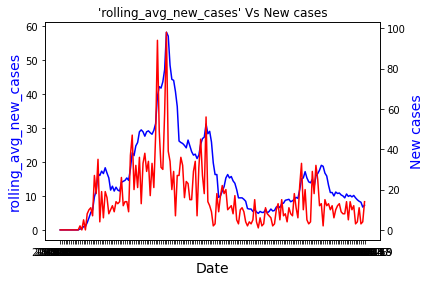

In [248]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.Date, albany_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(albany_county.Date, albany_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [249]:
suffolk_county = NY_combined_data[NY_combined_data['County Name'] == 'Suffolk County']

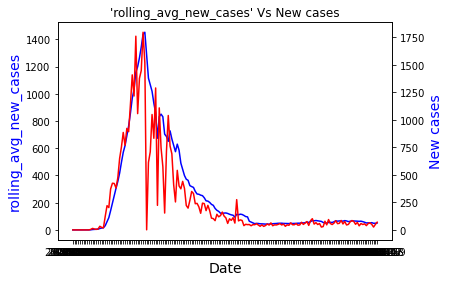

In [250]:
fig,ax = plt.subplots()
# make a plot
ax.plot(suffolk_county.Date, suffolk_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(suffolk_county.Date, suffolk_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [251]:
NY_combined_data = NY_combined_data.sort_values(by=['Date'])
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0
170,2020-03-01,36003,Allegany County,47.0,13.0,0.0,0.0,1.0,0.0,19.81,0.707,12,44.778541,0,0.0,0,0.0
9520,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0
9180,2020-03-01,36119,Westchester County,8.0,-1.0,12.0,1.0,0.0,0.0,-4.34,3.903,59,2247.400697,0,0.0,0,0.0
2380,2020-03-01,36031,Essex County,16.0,11.0,17.0,0.0,1.0,0.0,60.18,12.600,197,20.557565,0,0.0,0,0.0


In [252]:
NY_combined_data[NY_combined_data['fips_x'] == 36001]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.000,0,0.000000
1,2020-03-02,36001,Albany County,11.0,15.0,29.0,5.0,3.0,0.0,4.02,4.680,97,584.364958,0,0.000,0,0.000000
2,2020-03-03,36001,Albany County,8.0,15.0,41.0,8.0,3.0,-1.0,12.09,4.778,100,584.364958,0,0.000,0,0.000000
3,2020-03-04,36001,Albany County,7.0,8.0,6.0,2.0,3.0,0.0,11.97,4.486,93,584.364958,0,0.000,0,0.000000
4,2020-03-05,36001,Albany County,5.0,13.0,18.0,2.0,3.0,-1.0,18.74,5.129,107,584.364958,0,0.000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2020-08-15,36001,Albany County,-33.0,-11.0,0.0,-31.0,-15.0,1.0,39.76,3.419,71,584.364958,1,0.788,4,8.857143
166,2020-08-16,36001,Albany County,-28.0,-10.0,0.0,-34.0,-14.0,1.0,16.22,1.363,28,584.364958,1,0.788,11,8.428571
167,2020-08-17,36001,Albany County,-21.0,1.0,76.0,-36.0,-45.0,12.0,37.64,2.712,56,584.364958,1,0.788,3,8.142857
168,2020-08-18,36001,Albany County,0.0,0.0,0.0,0.0,0.0,0.0,44.94,3.480,72,584.364958,1,0.788,4,6.714286


In [253]:
minDate = NY_combined_data['Date'].min()
print(minDate)

dateList = NY_combined_data['Date'].unique()

2020-03-01


In [254]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [255]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)
  


[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-19']


In [256]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28


## Slice data for the week dataframe

In [257]:

average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)


In [258]:
average_newCases_df.shape

(741, 5)

In [259]:
average_newCases_df[average_newCases_df['fips_x'] == 36001]

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
0,Albany County,36001,11.122449,2020-03-15,2020-03-28
0,Albany County,36001,14.785714,2020-03-29,2020-04-11
0,Albany County,36001,30.132653,2020-04-12,2020-04-26
0,Albany County,36001,40.244898,2020-04-27,2020-05-10
0,Albany County,36001,25.234694,2020-05-11,2020-05-24
0,Albany County,36001,15.183673,2020-05-25,2020-06-08
0,Albany County,36001,7.367347,2020-06-09,2020-06-22
0,Albany County,36001,6.336735,2020-06-23,2020-07-06
0,Albany County,36001,11.795918,2020-07-07,2020-07-20


## Verifying average per week data Eg., albany County

In [260]:
albany_county[(albany_county['Date'] >= '2020-03-01') & (albany_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']



0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.285714
12    0.285714
13    1.000000
Name: rolling_avg_new_cases, dtype: float64

In [261]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14
2,Broome County,36007,0.020408,2020-03-01,2020-03-14
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14
5,Chautauqua County,36013,0.000000,2020-03-01,2020-03-14
6,Chemung County,36015,0.000000,2020-03-01,2020-03-14
7,Chenango County,36017,0.000000,2020-03-01,2020-03-14
8,Clinton County,36019,0.000000,2020-03-01,2020-03-14
9,Columbia County,36021,0.000000,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [262]:
average_newCases_df_ = average_newCases_df.copy()

In [263]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Albany County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
0,Albany County,36001,11.122449,2020-03-15,2020-03-28
0,Albany County,36001,14.785714,2020-03-29,2020-04-11
0,Albany County,36001,30.132653,2020-04-12,2020-04-26
0,Albany County,36001,40.244898,2020-04-27,2020-05-10
0,Albany County,36001,25.234694,2020-05-11,2020-05-24
0,Albany County,36001,15.183673,2020-05-25,2020-06-08
0,Albany County,36001,7.367347,2020-06-09,2020-06-22
0,Albany County,36001,6.336735,2020-06-23,2020-07-06
0,Albany County,36001,11.795918,2020-07-07,2020-07-20


In [264]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [265]:
average_newCases_df.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14
2,Broome County,36007,0.020408,2020-03-01,2020-03-14
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14


In [266]:
# average_newCases_df = average_newCases_df.sort_values(by=['startDate','endDate'])

# print(average_newCases_df.shape)
# temp = average_newCases_df.groupby(['County Name','fips_x','startDate','endDate'])['average_per_week']
# temp = temp.sum().diff().reset_index()
# print("-------------")
# print(temp)
# print(temp.shape)

# average_newCases_df2 = average_newCases_df.merge(temp,on=['County Name','fips_x','startDate','endDate'])
# print(average_newCases_df2.shape)

In [267]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Albany County,36001,0.112245,2020-03-01,2020-03-14
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14
2,Broome County,36007,0.020408,2020-03-01,2020-03-14
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14


In [268]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()


(741, 6)


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0


In [269]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
56,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000
113,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000
170,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837
227,Yates County,36123,0.714286,2020-04-12,2020-04-26,0.622449
284,Yates County,36123,0.520408,2020-04-27,2020-05-10,-0.193878
341,Yates County,36123,0.918367,2020-05-11,2020-05-24,0.397959
398,Yates County,36123,0.469388,2020-05-25,2020-06-08,-0.448980
455,Yates County,36123,0.112245,2020-06-09,2020-06-22,-0.357143
512,Yates County,36123,0.448980,2020-06-23,2020-07-06,0.336735
569,Yates County,36123,0.255102,2020-07-07,2020-07-20,-0.193878


In [270]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Albany County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.000000
57,Albany County,36001,11.122449,2020-03-15,2020-03-28,11.010204
114,Albany County,36001,14.785714,2020-03-29,2020-04-11,3.663265
171,Albany County,36001,30.132653,2020-04-12,2020-04-26,15.346939
228,Albany County,36001,40.244898,2020-04-27,2020-05-10,10.112245
285,Albany County,36001,25.234694,2020-05-11,2020-05-24,-15.010204
342,Albany County,36001,15.183673,2020-05-25,2020-06-08,-10.051020
399,Albany County,36001,7.367347,2020-06-09,2020-06-22,-7.816327
456,Albany County,36001,6.336735,2020-06-23,2020-07-06,-1.030612
513,Albany County,36001,11.795918,2020-07-07,2020-07-20,5.459184


In [271]:
average_newCases_df2[average_newCases_df2['fips_x'] == 36071].head(5)

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
32,Orange County,36071,0.112245,2020-03-01,2020-03-14,0.000000
89,Orange County,36071,46.153061,2020-03-15,2020-03-28,46.040816
146,Orange County,36071,242.632653,2020-03-29,2020-04-11,196.479592
203,Orange County,36071,228.908163,2020-04-12,2020-04-26,-13.724490
260,Orange County,36071,146.816327,2020-04-27,2020-05-10,-82.091837


In [272]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
56,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000
113,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000
170,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837
227,Yates County,36123,0.714286,2020-04-12,2020-04-26,0.622449
284,Yates County,36123,0.520408,2020-04-27,2020-05-10,-0.193878
341,Yates County,36123,0.918367,2020-05-11,2020-05-24,0.397959
398,Yates County,36123,0.469388,2020-05-25,2020-06-08,-0.448980
455,Yates County,36123,0.112245,2020-06-09,2020-06-22,-0.357143
512,Yates County,36123,0.448980,2020-06-23,2020-07-06,0.336735
569,Yates County,36123,0.255102,2020-07-07,2020-07-20,-0.193878


In [273]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0


In [274]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [275]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0


In [276]:
#not working
#average_newCases_df2['pct_change_newcases'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x','startDate','endDate']).average_per_week_y.pct_change()

Shifting average_per_week_x	 column value for formula. Means previous row's value will be come to the current row.

In [277]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].shift()

In [278]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
County Name   fips_x startDate  endDate                       ...             
Albany County 36001  2020-03-01 2020-03-14          0.112245  ...     0.000000
                     2020-03-15 2020-03-28         11.122449  ...     0.112245
                     2020-03-29 2020-04-11         14.785714  ...    11.122449
                     2020-04-12 2020-04-26         30.132653  ...    14.785714
                     2020-04-27 2020-05-10         40.244898  ...    30.132653
...                                                      ...  ...          ...
Yates County  36123  2020-06-23 2020-07-06          0.448980  ...     0.112245
                     2020-07-07 2020-07-20          0.255102  ...     0.448980
                     2020-07-21 2020-08-03          0.214286  ...     0.255102
                     2020-08-04 2020-08-17          0.336735  ...     0.214286
                     2020-08-18 2020-08-19          0.285714  ...     0.336735

[741 rows x 3 columns]

In [279]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
56,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000,NaN
113,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000,0.000000
170,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837,0.000000
227,Yates County,36123,0.714286,2020-04-12,2020-04-26,0.622449,0.091837
284,Yates County,36123,0.520408,2020-04-27,2020-05-10,-0.193878,0.714286
341,Yates County,36123,0.918367,2020-05-11,2020-05-24,0.397959,0.520408
398,Yates County,36123,0.469388,2020-05-25,2020-06-08,-0.448980,0.918367
455,Yates County,36123,0.112245,2020-06-09,2020-06-22,-0.357143,0.469388
512,Yates County,36123,0.448980,2020-06-23,2020-07-06,0.336735,0.112245
569,Yates County,36123,0.255102,2020-07-07,2020-07-20,-0.193878,0.448980


In [280]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
736,Washington County,36115,0.285714,2020-08-18,2020-08-19,-0.142857,0.428571,-0.333333
737,Wayne County,36117,2.142857,2020-08-18,2020-08-19,0.785714,1.357143,0.578947
738,Westchester County,36119,36.214286,2020-08-18,2020-08-19,3.714286,32.500000,0.114286
739,Wyoming County,36121,0.285714,2020-08-18,2020-08-19,-0.163265,0.448980,-0.363636
740,Yates County,36123,0.285714,2020-08-18,2020-08-19,-0.051020,0.336735,-0.151515


In [281]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Yates County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
56,Yates County,36123,0.000000,2020-03-01,2020-03-14,0.000000,NaN,0.000000
113,Yates County,36123,0.000000,2020-03-15,2020-03-28,0.000000,0.000000,0.000000
170,Yates County,36123,0.091837,2020-03-29,2020-04-11,0.091837,0.000000,0.000000
227,Yates County,36123,0.714286,2020-04-12,2020-04-26,0.622449,0.091837,6.777778
284,Yates County,36123,0.520408,2020-04-27,2020-05-10,-0.193878,0.714286,-0.271429
341,Yates County,36123,0.918367,2020-05-11,2020-05-24,0.397959,0.520408,0.764706
398,Yates County,36123,0.469388,2020-05-25,2020-06-08,-0.448980,0.918367,-0.488889
455,Yates County,36123,0.112245,2020-06-09,2020-06-22,-0.357143,0.469388,-0.760870
512,Yates County,36123,0.448980,2020-06-23,2020-07-06,0.336735,0.112245,3.000000
569,Yates County,36123,0.255102,2020-07-07,2020-07-20,-0.193878,0.448980,-0.431818


# Labeling data as per % change

In [282]:
average_newCases_df2.describe()

,fips_x,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,741.000000,741.000000,741.000000,684.000000,741.000000
mean,36062.894737,41.117078,0.847462,43.597282,3.891172
std,36.194441,272.641607,168.619574,283.357582,27.538944
min,36001.000000,-0.030612,-2068.877551,-0.030612,-1.136364
25%,36031.000000,0.428571,-0.714286,0.438776,-0.331900
50%,36063.000000,1.367347,0.000000,1.382653,0.000000
75%,36095.000000,6.336735,0.653061,6.678571,0.377934
max,36123.000000,4532.551020,3192.632653,4532.551020,410.181818


In [283]:
albany_county = average_newCases_df2[average_newCases_df2['County Name'] == 'Suffolk County']

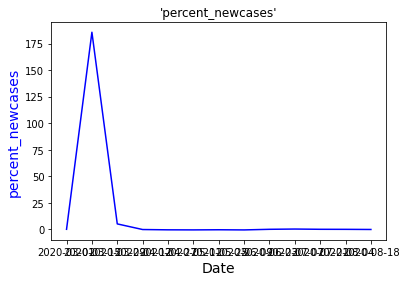

In [284]:
fig,ax = plt.subplots()
# make a plot
ax.plot(albany_county.startDate, albany_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(albany_county.startDate, albany_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [285]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 98.09090909090911, 0.0, 39.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.000000000000002, 140.00000000000003, 380.6666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 11.333333333333334, 0.0, 0.0, 0.0, 0.0, 175.79999999999998, 0.0, 106.37885462555064, 213.91325695581014, 0.0, 0.0, 0.0, 0.0, 410.1818181818182, 0.0, 0.0, 0.0, 0.0, 0.0, 170.28571428571428, 23.764705882352946, 179.50000000000006, 0.0, 0.0, 0.0, 0.0, 0.0, 185.66666666666666, 0.0, 12.0, 165.00000000000003, 21.421052631578945, 0.0, 0.0, 0.0, 39.33373493975903, 0.0, 0.0, 0.32935779816513777, 8.357142857142858, 6.123456790123455, 102.00000000000003, 9.800000000000002, 8.615384615384615, 7.657894736842104, 12.759999999999998, 2.672413793103449, 1.559210526315789

In [286]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

## Jenks Natural breaks 

In [287]:
!pip install jenkspy


In [288]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]


In [289]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-1.1363636363636362, 3.6428571428571432, 13.625000000000002, 39.5, 106.37885462555064, 140.00000000000003, 185.66666666666666, 213.91325695581014, 410.1818181818182]


### Labeling criteria

We have applied "jenks Natural breaks' to label the county data as per 'percent change in cases'

From the natural break algorithm, we have splited the data as follows 

* -1.136 to 3.642 is **label 1** (least chance of spreading) 

* 3.642 to 13.625 is **label 2** (Below threshold but chances to reach super spread level)

* 13.625 to 410.181818 is **label 3** (Super spread week)

In [290]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [291]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['County Name'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['County Name'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['County Name'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['County Name'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['County Name'].count())




Number of records in LessSpread: 680
Number of records in Spread: 42
Number of records in SuperSpread: 6
Number of records in SuperSpread2: 3
Number of records in SuperSpread3: 1
Number of records in SuperSpread4: 5
Number of records in SuperSpread5: 1
Number of records in SuperSpread6: 2


In [292]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,labels
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,LessSpread


# Labeling data for NY combined

In [293]:
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0
170,2020-03-01,36003,Allegany County,47.0,13.0,0.0,0.0,1.0,0.0,19.81,0.707,12,44.778541,0,0.0,0,0.0
9520,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0
9180,2020-03-01,36119,Westchester County,8.0,-1.0,12.0,1.0,0.0,0.0,-4.34,3.903,59,2247.400697,0,0.0,0,0.0
2380,2020-03-01,36031,Essex County,16.0,11.0,17.0,0.0,1.0,0.0,60.18,12.600,197,20.557565,0,0.0,0,0.0


In [294]:
NY_combined_data_ = NY_combined_data.copy()



In [295]:
NY_combined_data = NY_combined_data_.copy().reset_index(drop=True)

In [296]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (NY_combined_data['fips_x'] == row['fips_x']) & (NY_combined_data['Date'] >= startDate) & (NY_combined_data['Date'] <= endDate)
    df_weekData =  NY_combined_data.loc[df_index]
    #print(df_weekData)
    NY_combined_data.loc[df_index,'label'] = row['labels']




In [297]:
NY_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label
0,2020-03-01,36001,Albany County,10.0,13.0,19.0,4.0,7.0,-1.0,-4.87,2.616,54,584.364958,0,0.0,0,0.0,LessSpread
1,2020-03-01,36003,Allegany County,47.0,13.0,0.0,0.0,1.0,0.0,19.81,0.707,12,44.778541,0,0.0,0,0.0,LessSpread
2,2020-03-01,36123,Yates County,31.0,33.0,0.0,0.0,7.0,0.0,28.14,5.004,72,73.676584,0,0.0,0,0.0,LessSpread
3,2020-03-01,36119,Westchester County,8.0,-1.0,12.0,1.0,0.0,0.0,-4.34,3.903,59,2247.400697,0,0.0,0,0.0,LessSpread
4,2020-03-01,36031,Essex County,16.0,11.0,17.0,0.0,1.0,0.0,60.18,12.600,197,20.557565,0,0.0,0,0.0,LessSpread


In [298]:
NY_combined_data[NY_combined_data['label'] == 'SuperSpread'].sort_values(by=['fips_x','Date'])

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label


In [299]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,labels


## Kernal Density Estimation

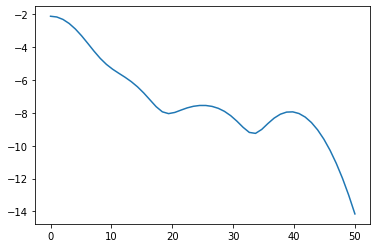

In [300]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [301]:


from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]


In [313]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

19.387755102040817

In [302]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

[-1.1363636363636362, 39.5, 213.91325695581014, 410.1818181818182]

Minima: [19.3877551  33.67346939]
Maxima: [24.48979592 39.79591837]*italicized text*

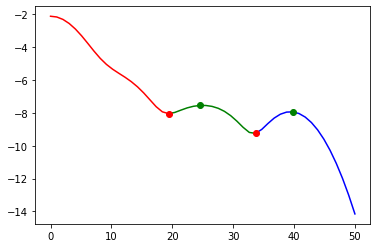

In [303]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


## Labeling Data with Kernal density results

In [311]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0


In [330]:
print(lower_range, upper_range)

19.387755102040817 33.673469387755105


In [323]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [324]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))



#converter = lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)



In [328]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

County Name         723
fips_x              723
average_per_week    723
startDate           723
endDate             723
diff_avg_x          723
shift_avg_x         666
percent_newcases    723
label               723
dtype: int64

In [329]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

County Name         4
fips_x              4
average_per_week    4
startDate           4
endDate             4
diff_avg_x          4
shift_avg_x         4
percent_newcases    4
label               4
dtype: int64

In [327]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

County Name         14
fips_x              14
average_per_week    14
startDate           14
endDate             14
diff_avg_x          14
shift_avg_x         14
percent_newcases    14
label               14
dtype: int64

In [325]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,label
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread


# unused code


In [305]:
average_newCases_df2[average_newCases_df2['County Name'] != 'Queens County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,labels
0,Albany County,36001,0.112245,2020-03-01,2020-03-14,0.000000,NaN,0.000000,LessSpread
1,Allegany County,36003,0.000000,2020-03-01,2020-03-14,0.000000,NaN,0.000000,LessSpread
2,Broome County,36007,0.020408,2020-03-01,2020-03-14,0.000000,NaN,0.000000,LessSpread
3,Cattaraugus County,36009,0.000000,2020-03-01,2020-03-14,0.000000,NaN,0.000000,LessSpread
4,Cayuga County,36011,0.000000,2020-03-01,2020-03-14,0.000000,NaN,0.000000,LessSpread
...,...,...,...,...,...,...,...,...,...
736,Washington County,36115,0.285714,2020-08-18,2020-08-19,-0.142857,0.428571,-0.333333,LessSpread
737,Wayne County,36117,2.142857,2020-08-18,2020-08-19,0.785714,1.357143,0.578947,LessSpread
738,Westchester County,36119,36.214286,2020-08-18,2020-08-19,3.714286,32.500000,0.114286,LessSpread
739,Wyoming County,36121,0.285714,2020-08-18,2020-08-19,-0.163265,0.448980,-0.363636,LessSpread


In [306]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  percent_newcases
County Name   fips_x startDate  endDate                       ...                  
Albany County 36001  2020-03-01 2020-03-14          0.112245  ...          0.000000
                     2020-03-15 2020-03-28         11.122449  ...         98.090909
                     2020-03-29 2020-04-11         14.785714  ...          0.329358
                     2020-04-12 2020-04-26         30.132653  ...          1.037957
                     2020-04-27 2020-05-10         40.244898  ...          0.335591
...                                                      ...  ...               ...
Yates County  36123  2020-06-23 2020-07-06          0.448980  ...          3.000000
                     2020-07-07 2020-07-20          0.255102  ...         -0.431818
                     2020-07-21 2020-08-03          0.214286  ...         -0.160000
                     2020-08-04 2020-08-17          0.336735  ...          0.571429
                     2020-08-18 2020-08-19          0.285714  ...         -0.151515

[741 rows x 4 columns]

In [307]:
week_df.head()

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28
2,3,2020-03-29,2020-04-11
3,4,2020-04-12,2020-04-26
4,5,2020-04-27,2020-05-10


In [308]:
NY_combined_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
label                     object
dtype: object

In [309]:
start_date_df = (
    NY_combined_data
    .merge(week_df, left_on=['Date'],right_on=['startDate'], how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"starting_rolling_avg_new_cases": "rolling_avg_new_cases"})
    .reset_index(drop=True)

    [['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','startDate','WeekNumber','rolling_avg_new_cases']]
    .pivot_table(values='rolling_avg_new_cases', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

start_date_df

,County Name,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Albany County,0.0,1.000000,11.714286,24.714286,41.714286,24.142857,25.857143,11.857143,5.142857,8.857143,14.857143,10.714286,6.714286
1,Allegany County,0.0,0.000000,0.571429,1.428571,0.714286,0.428571,0.000000,0.428571,0.428571,0.571429,0.571429,0.142857,0.000000
2,Broome County,0.0,0.142857,3.714286,7.857143,8.857143,6.285714,13.714286,7.000000,2.142857,6.571429,10.857143,12.285714,4.857143
3,Cattaraugus County,0.0,0.000000,0.571429,2.571429,1.571429,1.142857,2.000000,0.857143,1.571429,0.714286,1.142857,1.571429,0.571429
4,Cayuga County,0.0,0.000000,0.285714,3.285714,1.714286,1.285714,1.714286,1.285714,0.285714,1.000000,0.571429,1.428571,1.000000
5,Chautauqua County,0.0,0.000000,1.000000,0.714286,0.714286,0.571429,3.714286,2.428571,1.142857,1.142857,3.714286,3.142857,1.857143
6,Chemung County,0.0,0.000000,2.142857,3.142857,5.000000,0.714286,0.285714,0.142857,0.142857,0.857143,0.857143,0.428571,2.000000
7,Chenango County,0.0,0.000000,1.857143,2.857143,2.428571,1.571429,0.142857,0.285714,0.285714,1.571429,2.428571,1.285714,0.000000
8,Clinton County,0.0,0.000000,1.285714,1.428571,1.142857,1.142857,0.142857,0.000000,0.142857,0.571429,0.571429,0.571429,0.714286
9,Columbia County,0.0,0.000000,1.857143,2.571429,5.000000,14.428571,3.714286,3.285714,1.714286,2.142857,0.857143,3.571429,1.714286


In [310]:
end_date_df = (
    NY_combined_data
    .merge(week_df, on='Date', how='inner')
    .pipe(lambda x: x.assign(date=x.Date))
    .rename(columns={"Confirmed": "end_date_Confirmed"})
    .reset_index(drop=True)

    [['County Name', 'fips_x', 'end_date_Confirmed','endDate','WeekNumber']]
    .pivot_table(values='end_date_Confirmed', columns='WeekNumber', index='County Name', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

KeyError: ignored